# Caso Práctico Final: Predicción de Fraude

El conjunto de datos para este caso práctico trata sobre fraude de cuentas bancarias (BAF) y se publicó en NeurIPS 2022. Comprende un total de 6 conjuntos de datos tabulares sintéticos diferentes sobre fraude de cuentas bancarias.

El enlace a la publicación puedes encontrarlo aquí:
[Enlace publicación](https://arxiv.org/pdf/2211.13358.pdf)

Para este caso práctico trabajaremos con el dataset preprocesado en el caso final de la asignatura Data Science: Análisis Exploratorio de Datos. Siempre es necesario preprocesar los datos para adaptarlos para que funcionen como entrada de un modelo de Machine Learning, de modo que aprovecharemos esta parte del trabajo ya hecha.


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Lectura de datos

Utiliza los datos que preocesaste en el caso final de la asignatura de Análisis Exploratorio de Datos, ya que en dicho caso práctico los datos obtenidos serían los necesarios para introducir a un modelo de machine learning.

In [2]:
#Lectura de datos
df = pd.read_csv("/content/drive/MyDrive/MACHINE_LEARNING/Base.csv")


### Análisis de la variable objetivo

Plotea un diagrama de barras de la variable objetivo y obten el porcentaje de ceros y unos ¿Qué observas?

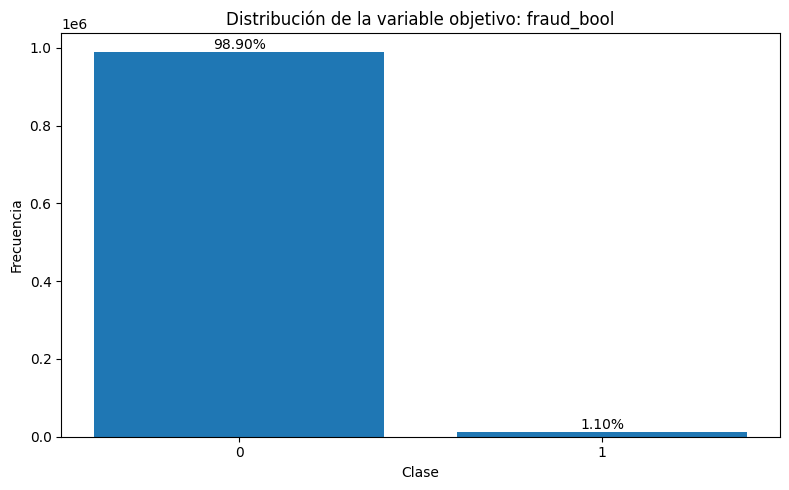

Porcentajes por clase:
fraud_bool
0    98.8971
1     1.1029
Imbalance ratio (mayoría/minoría): 89.67:1


In [3]:
# 2) Variable objetivo
target = "fraud_bool"

# 3) Conteos y porcentajes
counts = df[target].value_counts().sort_index()           # Índice: 0, 1
percentages = (counts / counts.sum() * 100).round(4)

# 4) Gráfico de barras
plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)          # No fijamos colores
plt.title(f"Distribución de la variable objetivo: {target}")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")

# Anotar porcentajes sobre cada barra
for x, y in zip(counts.index.astype(str), counts.values):
    pct = percentages.loc[int(x)]
    plt.text(x, y, f"{pct:.2f}%", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# 5) Mostrar porcentajes en consola
print("Porcentajes por clase:")
print(percentages.to_string())

# (Opcional) Ratio de desbalance
minority = counts.min()
majority = counts.max()
ratio = round(majority / minority, 2) if minority > 0 else float("inf")
print(f"Imbalance ratio (mayoría/minoría): {ratio}:1")


Se observa la clase 0 (no fraude) muy dominante (~98.9%) y una clase 1 minoritaria (1.1%), indicando desbalance fuerte.

# Clasificación

## Técnicas de balanceo

Hay diferentes técnicas que nos permiten lidiar con el desbalanceo de la variable objetivo. Aquí se describen algunas de ellas:

1. Remuestreo de datos:
    * Sobremuestreo (Oversampling): Aumenta el número de instancias de la clase minoritaria.
    * Submuestreo (Undersampling): Reduce el número de instancias de la clase mayoritaria.
    * Remuestreo combinado: Combina técnicas de sobremuestreo y submuestreo para equilibrar las clases.
2. Generación de muestras sintéticas:
    * SMOTE (Synthetic Minority Over-sampling Technique): Genera nuevas instancias sintéticas de la clase minoritaria mediante interpolación entre instancias similares.
3. Ponderación de clases:
    * Ajusta los pesos de las clases durante el entrenamiento para dar más importancia a la clase minoritaria.

A continuación genera diferentes datasets aplicando las diferentes técnicas e implementa un modelo de clasificación con cada uno de ellos y analiza las diferencias.


Las técnicas de balanceo se aplicarán sobre los conjuntos de entrenamiento. El conjunto de test debe de ser el inicial, que sea un conjunto que el modelo no haya visto ni haya sido modificado.

### Oversampling:
Implica duplicar instancias aleatorias de la clase minoritaria hasta que se equilibre con la clase mayoritaria.
El código para realizar esta ténica se proporciona.

In [4]:
#En primer lugar divido los datos en conjunto de entrenamiento y train.

X = df.drop(columns=[target])
y = df[target]

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Distribución en entrenamiento:\n", y_train.value_counts(normalize=True) * 100)


Tamaño del conjunto de entrenamiento: (800000, 31)
Tamaño del conjunto de prueba: (200000, 31)
Distribución en entrenamiento:
 fraud_bool
0    98.897125
1     1.102875
Name: proportion, dtype: float64


In [12]:
# ========= Preprocesado sin fuga =========
# Detectar tipos
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# --- Imputación con estadísticas del TRAIN ---
# Numéricas: mediana
num_medians = X_train[num_cols].median()
X_train[num_cols] = X_train[num_cols].fillna(num_medians)
X_test[num_cols]  = X_test[num_cols].fillna(num_medians)

# Categóricas: moda (si varias modas, tomar la primera)
cat_modes = {}
for c in cat_cols:
    mode_vals = X_train[c].mode(dropna=True)
    cat_modes[c] = mode_vals.iloc[0] if not mode_vals.empty else "MISSING"
X_train[cat_cols] = X_train[cat_cols].fillna(pd.Series(cat_modes))
X_test[cat_cols]  = X_test[cat_cols].fillna(pd.Series(cat_modes))

# --- One-hot en TRAIN y alinear TEST a mismas columnas ---
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
X_test_enc  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=False)

# Alinear columnas (agregar las que falten en test con 0 y reordenar)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Shape TRAIN original:", X_train.shape, " -> codificado:", X_train_enc.shape)
print("Shape TEST  original:", X_test.shape,  " -> codificado:", X_test_enc.shape)

# ========= 4) Oversampling SOLO en TRAIN =========
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_over, y_over = oversample.fit_resample(X_train_enc, y_train)

print("\nDistribución en TRAIN antes del oversampling:")
print(y_train.value_counts(normalize=True).rename("proportion"))
print("\nDistribución en TRAIN después del oversampling:")
print(y_over.value_counts(normalize=True).rename("proportion"))

# ========= 5) Modelo =========
clf = RandomForestClassifier(
    n_estimators=40,      # 40 árboles (rápido y suficiente)
    max_depth=12,         # evita árboles gigantes
    min_samples_leaf=5,   # poda ligera
    max_features="sqrt",  # usa subconjuntos de variables
    n_jobs=-1,
    random_state=42,
    verbose=1
)

clf.fit(X_over, y_over)

# ========= 6) Evaluación en TEST (intacto) =========
y_pred = clf.predict(X_test_enc)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== Random Forest con Oversampling (minority) ===")
print("Matriz de confusión:\n", cm)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

Shape TRAIN original: (800000, 31)  -> codificado: (800000, 52)
Shape TEST  original: (200000, 31)  -> codificado: (200000, 52)

Distribución en TRAIN antes del oversampling:
fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64

Distribución en TRAIN después del oversampling:
fraud_bool
0    0.5
1    0.5
Name: proportion, dtype: float64


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



=== Random Forest con Oversampling (minority) ===
Matriz de confusión:
 [[174375  23419]
 [   699   1507]]
Accuracy:  0.8794
Precision: 0.0605
Recall:    0.6831
F1-score:  0.1111


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    1.0s finished


### Oversampling dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de oversampling y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?


Tras aplicar codificación one-hot, las variables categóricas se transforman de 31 a 52 columnas, aumentando el número de características pero conservando la información de las categorías.

El conjunto de prueba no se modifica en tamaño ni proporciones; solo se alinea con las mismas columnas del entrenamiento.

El método RandomOverSampler duplica aleatoriamente los registros de la clase minoritaria hasta igualar la cantidad de la clase mayoritaria, resultando en un conjunto balanceado 50/50.

El modelo ahora sí detecta fraudes reales (Recall = 68%), lo que antes no conseguía.

Sin embargo, la precisión baja (6%) indica muchos falsos positivos: el modelo clasifica como “fraude” a muchas transacciones que no lo son.

El F1-score, aunque bajo, mejora significativamente respecto al dataset original.

Conclusión:
El Oversampling mejora la capacidad del modelo para reconocer la clase minoritaria (fraude), pero introduce muchas falsas alarmas, ya que las copias artificiales de casos minoritarios pueden inducir sobreajuste.



### Undersampling:
Implica eliminar instancias aleatorias de la clase mayoriataria hasta que se equilibre con la clase mayoritaria.
El código para realizar esta ténica se proporciona.

In [16]:
# ========= Undersampling SOLO en TRAIN =========
undersample_under = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_under, y_train_under = undersample_under.fit_resample(X_train_enc, y_train)

print("\nDistribución en TRAIN antes del undersampling:")
print(y_train.value_counts(normalize=True).rename("proportion"))
print("\nDistribución en TRAIN después del undersampling:")
print(y_train_under.value_counts(normalize=True).rename("proportion"))

# ========= 5) Modelo =========
clf_under = RandomForestClassifier(
    n_estimators=40,      # 40 árboles (rápido y suficiente)
    max_depth=12,         # evita árboles gigantes
    min_samples_leaf=5,   # poda ligera
    max_features="sqrt",  # usa subconjuntos de variables
    n_jobs=-1,
    random_state=42,
    verbose=1
)

clf_under.fit(X_train_under, y_train_under)

# ========= 6) Evaluación =========
y_pred_under = clf_under.predict(X_test_enc)

cm_under = confusion_matrix(y_test, y_pred_under)
acc_under = accuracy_score(y_test, y_pred_under)
prec_under = precision_score(y_test, y_pred_under, zero_division=0)
rec_under = recall_score(y_test, y_pred_under)
f1_under = f1_score(y_test, y_pred_under)

print("\n=== Random Forest con Undersampling (majority) ===")
print("Matriz de confusión:\n", cm_under)
print(f"Accuracy:  {acc_under:.4f}")
print(f"Precision: {prec_under:.4f}")
print(f"Recall:    {rec_under:.4f}")
print(f"F1-score:  {f1_under:.4f}")



Distribución en TRAIN antes del undersampling:
fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64

Distribución en TRAIN después del undersampling:
fraud_bool
0    0.5
1    0.5
Name: proportion, dtype: float64


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



=== Random Forest con Undersampling (majority) ===
Matriz de confusión:
 [[159131  38663]
 [   465   1741]]
Accuracy:  0.8044
Precision: 0.0431
Recall:    0.7892
F1-score:  0.0817


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    0.9s finished


### Undersampling dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de undersampling y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?

El undersampling ayudó al modelo a reconocer la clase minoritaria, elevando el recall a casi 0.8, lo que significa que detecta la mayoría de los fraudes.

Sin embargo, al eliminar gran parte de los datos no fraudulentos, el modelo pierde contexto y genera muchísimos falsos positivos, reduciendo la precisión.

El modelo detecta el 79 % de los fraudes reales (alto recall), similar o superior al oversampling.

Pero la precisión es incluso menor (4.3%), lo que significa que dispara muchas más alertas falsas.

La accuracy cae al 80 % porque el modelo ya no ve la distribución real de datos (perdió casi toda la información de la clase 0).

Conclusión:
El Undersampling también logra mejorar la detección de fraudes, pero a costa de eliminar demasiada información de la clase mayoritaria, lo que debilita la generalización y genera aún más falsos positivos.

Esto demuestra el riesgo principal del undersampling: aunque equilibra las clases, también descarta información útil de la clase mayoritaria.

### SMOTE:
SMOTE genera instancias sintéticas de la clase minoritaria basándose en los datos existentes, lo que reduce el riesgo de sobreajuste.
El código para realizar esta ténica se proporciona.

In [17]:
# ========= SMOTE SOLO en TRAIN =========
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_enc, y_train)

print("\nDistribución en TRAIN antes del SMOTE:")
print(y_train.value_counts(normalize=True).rename("proportion"))
print("\nDistribución en TRAIN después del SMOTE:")
print(y_resampled.value_counts(normalize=True).rename("proportion"))

# ========= 5) Modelo =========
clf_smote = RandomForestClassifier(
    n_estimators=40,      # 40 árboles (rápido y suficiente)
    max_depth=12,         # evita árboles gigantes
    min_samples_leaf=5,   # poda ligera
    max_features="sqrt",  # usa subconjuntos de variables
    n_jobs=-1,
    random_state=42,
    verbose=1
)

clf_smote.fit(X_resampled, y_resampled)

# ========= 6) Evaluación =========
y_pred_smote = clf_smote.predict(X_test_enc)

cm_smote = confusion_matrix(y_test, y_pred_smote)
acc_smote = accuracy_score(y_test, y_pred_smote)
prec_smote = precision_score(y_test, y_pred_smote, zero_division=0)
rec_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)

print("\n=== Random Forest con SMOTE ===")
print("Matriz de confusión:\n", cm_smote)
print(f"Accuracy:  {acc_smote:.4f}")
print(f"Precision: {prec_smote:.4f}")
print(f"Recall:    {rec_smote:.4f}")
print(f"F1-score:  {f1_smote:.4f}")



Distribución en TRAIN antes del SMOTE:
fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64

Distribución en TRAIN después del SMOTE:
fraud_bool
0    0.5
1    0.5
Name: proportion, dtype: float64


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



=== Random Forest con SMOTE ===
Matriz de confusión:
 [[190604   7190]
 [  1412    794]]
Accuracy:  0.9570
Precision: 0.0994
Recall:    0.3599
F1-score:  0.1558


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    1.0s finished


### SMOTE dataset
Entrena el modelo con el dataset sobre el que aplicaste la técnica de SMOTE y analiza sus métricas. ¿Qué observas? ¿Qué conclusiones puedes extraer?

El modelo detecta 794 fraudes reales de un total de 2,206, lo que representa un recall moderado (36%).

El número de falsos positivos (7,190) es menor que con oversampling o undersampling, mostrando una mejor precisión (≈10%).

Aun así, el modelo sigue clasificando erróneamente muchos no fraudes como fraudes.

## Modelado

Para este caso práctico aplicara el algoritmo Random Forest para calcular las predicciones. Aplica este modelo utilizando cada uno de los conjuntos de datos generados anteriormente y obtén las métricas para evaluar el rendimienot del modelo. ¿Qué técnica ha funcionado mejor?
¿Por qué?

Si no recuerdas como realizar un modelo de clasificación y su evaluación, puedes repasar lo visto en el caso práctico de la Unidad 1.

*Idea*:En el caso que creas necesario obtén las métricas de predicción sobre el conjunto de entrenamiento para analizar si hay overfitting.



### Dataset original:
Ejecuta el modelo y analiza sus métricas con el dataset original desbalanceado. ¿Qué observas? ¿Qué conclusiones puedes extraer?

In [19]:

# ========= 1) Modelo con datos originales (sin balancear) =========
clf_original = RandomForestClassifier(
    n_estimators=40,      # 40 árboles (rápido y suficiente)
    max_depth=12,         # evita árboles gigantes
    min_samples_leaf=5,   # poda ligera
    max_features="sqrt",  # usa subconjuntos de variables
    n_jobs=-1,
    random_state=42,
    verbose=1
)
clf_original.fit(X_train_enc, y_train)

# ========= 2) Predicciones y evaluación =========
y_pred_original = clf_original.predict(X_test_enc)

cm_original = confusion_matrix(y_test, y_pred_original)
acc_original = accuracy_score(y_test, y_pred_original)
prec_original = precision_score(y_test, y_pred_original, zero_division=0)
rec_original = recall_score(y_test, y_pred_original)
f1_original = f1_score(y_test, y_pred_original)

print("\n=== Random Forest con Dataset Original (sin balancear) ===")
print("Matriz de confusión:\n", cm_original)
print(f"Accuracy:  {acc_original:.4f}")
print(f"Precision: {prec_original:.4f}")
print(f"Recall:    {rec_original:.4f}")
print(f"F1-score:  {f1_original:.4f}")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



=== Random Forest con Dataset Original (sin balancear) ===
Matriz de confusión:
 [[197794      0]
 [  2205      1]]
Accuracy:  0.9890
Precision: 1.0000
Recall:    0.0005
F1-score:  0.0009


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    0.9s finished


El Random Forest entrenado con el dataset original desbalanceado obtiene una accuracy muy alta, pero no tiene valor práctico para el objetivo principal: detectar fraudes.

El modelo aprendió a predecir siempre “no fraude”, porque esa es la clase dominante.

En problemas con clases extremadamente desbalanceadas, la accuracy deja de ser una métrica útil; deben priorizarse recall, precision y F1-score para la clase minoritaria.

### Comparación de rendimiento

In [22]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ========= 1) Función de métricas generales =========
def get_metrics(y_true, y_pred, label):
    """
    Calcula Accuracy, Precision, Recall y F1-score para un conjunto de predicciones.
    """
    return {
        "Método": label,
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "Recall": round(recall_score(y_true, y_pred), 4),
        "F1-Score": round(f1_score(y_true, y_pred), 4)
    }

# ========= 2) Métricas en TEST =========
metrics_test = [
    get_metrics(y_test, y_pred_original, "Original (sin balanceo)"),
    get_metrics(y_test, y_pred, "Oversampling"),
    get_metrics(y_test, y_pred_under, "Undersampling"),
    get_metrics(y_test, y_pred_smote, "SMOTE")
]

df_metrics_test = pd.DataFrame(metrics_test)
print("=== MÉTRICAS EN TEST ===")
print(df_metrics_test.sort_values(by="F1-Score", ascending=False))

# ========= 3) Métricas en TRAIN (para detectar overfitting) =========
metrics_train = [
    get_metrics(y_train, clf_original.predict(X_train_enc), "Original (sin balanceo)"),
    get_metrics(y_over, clf.predict(X_over), "Oversampling"),
    get_metrics(y_train_under, clf_under.predict(X_train_under), "Undersampling"),
    get_metrics(y_resampled, clf_smote.predict(X_resampled), "SMOTE")
]

df_metrics_train = pd.DataFrame(metrics_train)
print("\n=== MÉTRICAS EN TRAIN ===")
print(df_metrics_train.sort_values(by="F1-Score", ascending=False))


=== MÉTRICAS EN TEST ===
                    Método  Accuracy  Precision  Recall  F1-Score
3                    SMOTE    0.9570     0.0994  0.3599    0.1558
1             Oversampling    0.8794     0.0605  0.6831    0.1111
2            Undersampling    0.8044     0.0431  0.7892    0.0817
0  Original (sin balanceo)    0.9890     1.0000  0.0005    0.0009


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    4.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    9.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    9.6s finished



=== MÉTRICAS EN TRAIN ===
                    Método  Accuracy  Precision  Recall  F1-Score
3                    SMOTE    0.9711     0.9643  0.9785    0.9714
1             Oversampling    0.8940     0.8848  0.9058    0.8952
2            Undersampling    0.8766     0.8819  0.8698    0.8758
0  Original (sin balanceo)    0.9890     1.0000  0.0025    0.0050


#### Conclusiones

¿Qué conclusiones sacas tras aplicar el modelo utilizando las diferentes técnicas?

Entre todas las técnicas probadas, SMOTE demuestra el mejor desempeño global, alcanzando el F1-score más alto y un equilibrio realista entre detección de fraudes (recall) y confiabilidad (precision).

Aunque Oversampling y Undersampling aumentan la sensibilidad, generan demasiados falsos positivos o pierden información valiosa.

En contextos reales donde detectar fraudes es prioritario, pero se busca minimizar falsas alarmas, SMOTE es la técnica más adecuada para entrenar modelos de clasificación con datos altamente desbalanceados.

# Clustering

En esta sección queremos segmentar los tipos de transacciones fraudulentas y no fraudulentas para analizar si hay tipos de transacciones con patrones comunes.
Para ello aplica un algoritmo de clustering. Tal y como aprendimos en la Unidad 2, utilizaremos k-Means.

Elimina la variable objetivo para la segmentación.

#### Dataset original

In [24]:
# ( df original codificado)
X_cluster = X_train_enc.copy()
y_cluster = y_train.copy()

# Elimina la variable objetivo si aún está presente
if 'fraud_bool' in X_cluster.columns:
    X_cluster = X_cluster.drop(columns=['fraud_bool'])

Aplica el método del codo para obtener el número óptimo de clusters previamente

Aplica el algoritmo k_means. Para cada conjunto de datos printea el número de registros que pertenen a dicho cluster y estadísticos de cada variable numérica. Para las variables binarias puedes graficar la cantidad de 0s y 1s por cluster.
¿Qué observas? ¿Tienen los clusters un tamaño similar?

*Idea*: Puedes guardar la media por ejemplo de cada variable por cluster en un dataframe, de forma que tengas todos los valores agrupados y se más fácil de comparar.

In [25]:
# ========= Escalado de variables numéricas =========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# ========= Aplica K-Means =========
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Agrega los labels al DataFrame
df_clusters = X_cluster.copy()
df_clusters['cluster'] = clusters


Número de registros por cluster:
cluster
0    403781
1    396219
Name: count, dtype: int64

Media de variables numéricas por cluster:
           income  name_email_similarity  prev_address_months_count  \
cluster                                                               
0        0.502065               0.508513                  19.437532   
1        0.624816               0.478801                  13.912215   

         current_address_months_count  customer_age  days_since_request  \
cluster                                                                   
0                           77.872012     31.048390            1.493478   
1                           95.523084     36.402368            0.545762   

         intended_balcon_amount  zip_count_4w  velocity_6h  velocity_24h  \
cluster                                                                    
0                     11.058361   1854.872956  7061.218894   5574.864459   
1                      6.226161   1285.274636  4240

/tmp/ipython-input-2844554067.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df_clusters, palette='viridis')


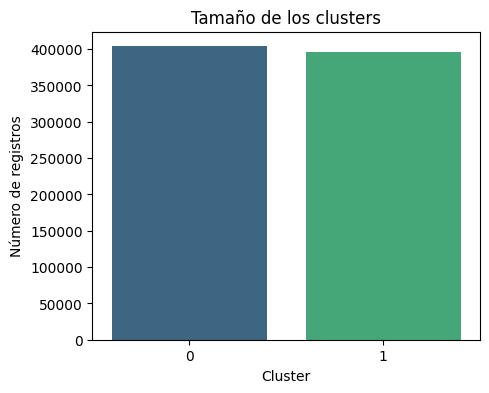

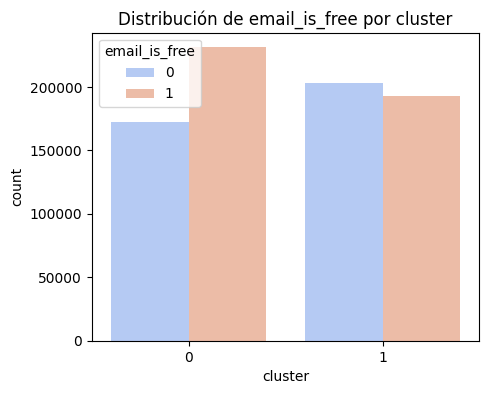

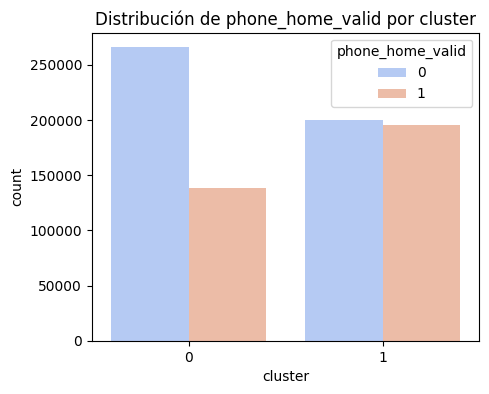

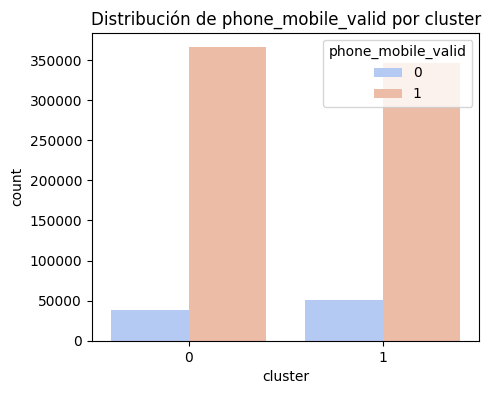

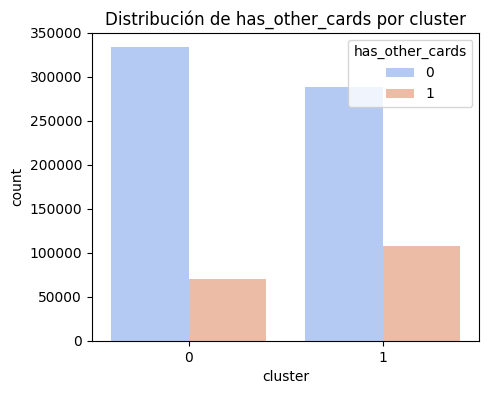

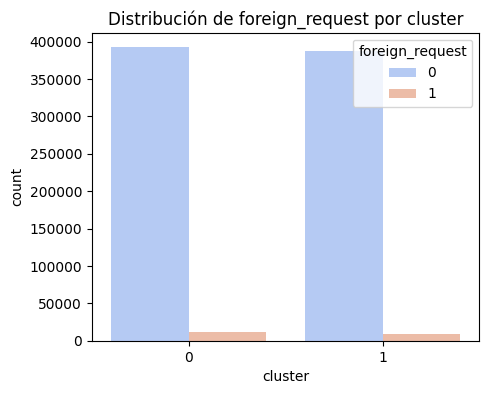


Resumen de medias guardado en 'cluster_summary.csv'


In [26]:
# =========  Análisis general de clusters =========
print("\nNúmero de registros por cluster:")
print(df_clusters['cluster'].value_counts())

print("\nMedia de variables numéricas por cluster:")
cluster_means = df_clusters.groupby('cluster').mean(numeric_only=True)
print(cluster_means.head())

# =========  Visualización de tamaños de cluster =========
plt.figure(figsize=(5,4))
sns.countplot(x='cluster', data=df_clusters, palette='viridis')
plt.title('Tamaño de los clusters')
plt.xlabel('Cluster')
plt.ylabel('Número de registros')
plt.show()

# =========  Distribución de variables binarias por cluster =========
binary_cols = [col for col in X_cluster.columns if set(X_cluster[col].unique()) <= {0,1}]

for col in binary_cols[:5]:  # puedes ajustar el número de variables a visualizar
    plt.figure(figsize=(5,4))
    sns.countplot(x='cluster', hue=col, data=df_clusters, palette='coolwarm')
    plt.title(f'Distribución de {col} por cluster')
    plt.show()

# =========  Guardar medias agrupadas =========
cluster_summary = df_clusters.groupby('cluster').mean(numeric_only=True).reset_index()
cluster_summary.to_csv("cluster_summary.csv", index=False)
print("\nResumen de medias guardado en 'cluster_summary.csv'")


=== Distribución de fraudes por cluster ===
Fraude        0     1
Cluster              
0        401275  2506
1        389902  6317

=== Proporción de fraudes dentro de cada cluster ===
Fraude        0      1
Cluster               
0        99.379  0.621
1        98.406  1.594


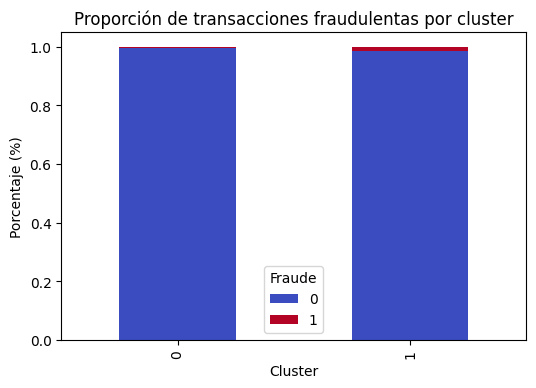

In [27]:
# ========= Cruce de clusters con la variable objetivo =========

# Agregamos la etiqueta de fraude al DataFrame de clusters
df_clusters['fraud_bool'] = y_cluster.values

# Tabla cruzada de frecuencia
fraud_by_cluster = pd.crosstab(df_clusters['cluster'], df_clusters['fraud_bool'],
                               rownames=['Cluster'], colnames=['Fraude'])

# Proporciones por cluster
fraud_prop = fraud_by_cluster.div(fraud_by_cluster.sum(axis=1), axis=0)

print("\n=== Distribución de fraudes por cluster ===")
print(fraud_by_cluster)
print("\n=== Proporción de fraudes dentro de cada cluster ===")
print((fraud_prop * 100).round(3))

# Visualización
fraud_prop.plot(kind='bar', stacked=True, figsize=(6,4), colormap='coolwarm')
plt.title('Proporción de transacciones fraudulentas por cluster')
plt.ylabel('Porcentaje (%)')
plt.show()


El Cluster 1 presenta una proporción de fraudes más del doble que el Cluster 0 (1.59 % vs. 0.62 %).

Aunque la diferencia absoluta parezca pequeña, la concentración relativa de fraude en el Cluster 1 es significativamente mayor, lo cual sugiere que K-Means logró captar patrones comportamentales asociados con riesgo de fraude.

Recordemos que el algoritmo no utilizó la variable fraud_bool para agrupar, por lo tanto, esta diferenciación surge de las características transaccionales.

K-Means ha segmentado las transacciones en dos grupos bien diferenciados en términos de perfil socioeconómico y comportamiento transaccional.

El Cluster 1, caracterizado por ingresos mayores, mayor edad y menor velocidad transaccional, concentra más casos de fraude, lo que puede deberse a operaciones de monto más alto o mayor atractivo para ataques selectivos.

El Cluster 0 agrupa transacciones de usuarios más jóvenes, digitales y de alta frecuencia, con una tasa de fraude menor pero no nula.

Aunque el modelo de clustering no utiliza etiquetas, logra distinguir dos perfiles de comportamiento con distinta incidencia de fraude.
Esto demuestra que el análisis no supervisado puede revelar segmentos de riesgo útiles para ajustar estrategias de prevención o priorizar la vigilancia de ciertos tipos de transacciones.

#### Sólo fraude

Ahora realiza la clusterización sólo seleccionando las transacciones fraudulentas

In [29]:
# ========= 1) Filtrar solo las transacciones fraudulentas =========
fraud_data = X_train_enc.copy()
fraud_data['fraud_bool'] = y_train.values
fraud_only = fraud_data[fraud_data['fraud_bool'] == 1].drop(columns=['fraud_bool'])

print(f"Número de transacciones fraudulentas: {fraud_only.shape[0]}")

# ========= 2) Escalado de variables =========
scaler = StandardScaler()
fraud_scaled = scaler.fit_transform(fraud_only)


Número de transacciones fraudulentas: 8823


Aplica el método del codo para obtener el número óptimo de clusters previamente

Número de transacciones fraudulentas: 8823


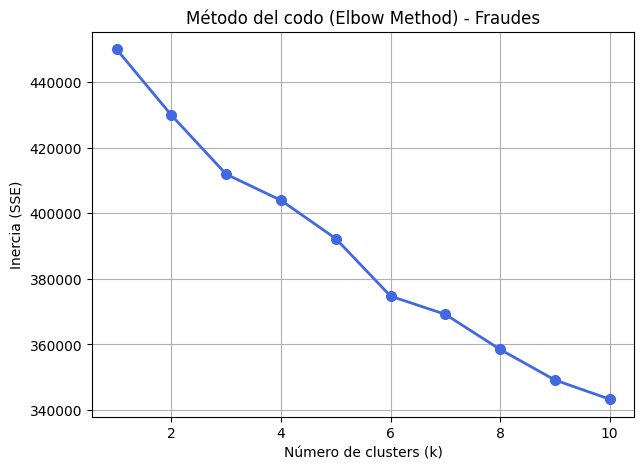

In [30]:
# ========= 1) Filtrar solo las transacciones fraudulentas =========
fraud_data = X_train_enc.copy()
fraud_data['fraud_bool'] = y_train.values
fraud_only = fraud_data[fraud_data['fraud_bool'] == 1].drop(columns=['fraud_bool'])

print(f"Número de transacciones fraudulentas: {fraud_only.shape[0]}")

# ========= 2) Escalar las variables =========
scaler = StandardScaler()
fraud_scaled = scaler.fit_transform(fraud_only)

# ========= 3) Calcular la inercia (SSE) para distintos valores de k =========
inertia = []
K = range(1, 11)  # probamos entre 1 y 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(fraud_scaled)
    inertia.append(kmeans.inertia_)  # suma de distancias cuadradas dentro de los clusters

# ========= 4) Graficar el método del codo =========
plt.figure(figsize=(7,5))
plt.plot(K, inertia, 'o-', color='royalblue', linewidth=2, markersize=7)
plt.title('Método del codo (Elbow Method) - Fraudes')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.grid(True)
plt.show()


Aplica el algoritmo k_means. Para cada conjunto de datos printea el número de registros que pertenen a dicho cluster y estadísticos de cada variable numérica. Para las variables binarias puedes graficar la cantidad de 0s y 1s por cluster.
¿Qué observas? ¿Tienen los clusters un tamaño similar?

*Idea*: Puedes guardar la media por ejemplo de cada variable por cluster en un dataframe, de forma que tengas todos los valores agrupados y se más fácil de comparar.


Número de registros fraudulentos por cluster:
cluster
0    4986
1    3750
2      87
Name: count, dtype: int64

Media de variables numéricas por cluster:
           income  name_email_similarity  prev_address_months_count  \
cluster                                                               
0        0.741777               0.392266                   4.750301   
1        0.615627               0.395939                   7.595467   
2        0.641379               0.396428                   3.402299   

         current_address_months_count  customer_age  days_since_request  \
cluster                                                                   
0                          124.246290     42.697553            0.673698   
1                          100.574400     38.498667            1.612325   
2                          122.712644     42.413793            0.992816   

         intended_balcon_amount  zip_count_4w  velocity_6h  velocity_24h  \
cluster                               

/tmp/ipython-input-2933137562.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=fraud_only_df, palette='mako')


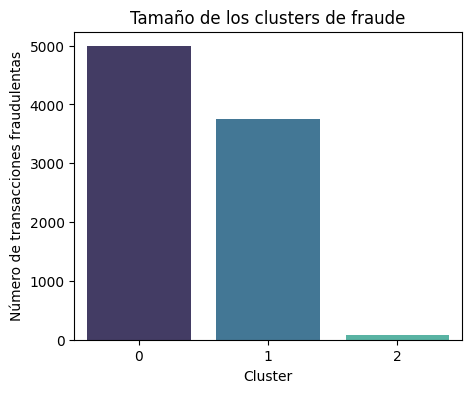


Resumen de clusters de fraude guardado en 'fraud_clusters_summary.csv'


In [31]:

# ========= 3) Aplicar K-Means =========
# probamos con k=3 para explorar posibles subtipos de fraude
kmeans_fraud = KMeans(n_clusters=3, random_state=42, n_init=10)
fraud_clusters = kmeans_fraud.fit_predict(fraud_scaled)

# Añadimos los clusters al DataFrame
fraud_only_df = fraud_only.copy()
fraud_only_df['cluster'] = fraud_clusters

# ========= 4) Tamaño de cada cluster =========
print("\nNúmero de registros fraudulentos por cluster:")
print(fraud_only_df['cluster'].value_counts())

# ========= 5) Medias de variables numéricas =========
print("\nMedia de variables numéricas por cluster:")
fraud_cluster_means = fraud_only_df.groupby('cluster').mean(numeric_only=True)
print(fraud_cluster_means.head())

# ========= 6) Visualización de tamaño =========
plt.figure(figsize=(5,4))
sns.countplot(x='cluster', data=fraud_only_df, palette='mako')
plt.title('Tamaño de los clusters de fraude')
plt.xlabel('Cluster')
plt.ylabel('Número de transacciones fraudulentas')
plt.show()

# ========= 7) Guardar resumen =========
fraud_summary = fraud_only_df.groupby('cluster').mean(numeric_only=True).reset_index()
fraud_summary.to_csv("fraud_clusters_summary.csv", index=False)
print("\nResumen de clusters de fraude guardado en 'fraud_clusters_summary.csv'")

El modelo de K-Means generó tres grupos, pero el Cluster 2 es muy pequeño (solo el 1%), lo que sugiere que puede representar casos muy particulares o atípicos — posiblemente outliers o un subtipo de fraude minoritario.
Los Clusters 0 y 1, en cambio, agrupan la gran mayoría de los fraudes y muestran patrones bien diferenciados.

El análisis de K-Means aplicado exclusivamente a las transacciones fraudulentas revela tres subtipos de fraude con patrones distintos.

Los fraudes masivos (Cluster 1) son los más comunes y dinámicos.

Los selectivos (Cluster 0) implican montos más altos y usuarios de perfil sólido.

El Cluster 2 agrupa pocos casos telefónicos o atípicos.

Estos hallazgos confirman que el fraude financiero no es homogéneo, y que la detección preventiva debe adaptarse a los diferentes patrones de comportamiento.

#### k-Means sobre PCA dataset

Dado que vimos que k-Means es un algoritmo basado en distancias, dijimos que era mejor normalizar los datos. Pero también es muy beneficioso utilizar un dataset en el que hemos reducido su dimensionalidad.
Es una práctica común aplicar PCA antes de un algoritmo de agrupamiento (como k-means) ya que  puede mejorar los resultados de la agrupación en debido a que reducce de ruido.

Utiliza el dataset del Caso Práctico Final de la asignatura de Análisis Exploratorio de Datos en el que aplicabas un PCA sobre tres componentes principales y sobre este dataset aplica k-Means.

Obtén mediante el método del codo el número de clusters idóneo. Realiza un k-means y analiza sus resultados.


Varianza explicada por cada componente PCA:
Componente 1: 0.0635
Componente 2: 0.0495
Componente 3: 0.0477
Varianza total explicada: 0.1606


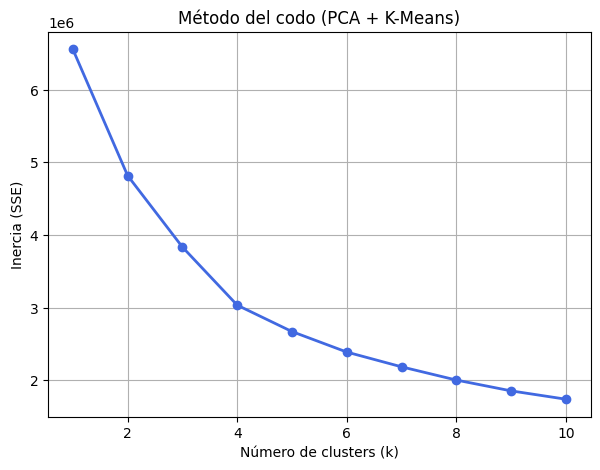


Número de registros por cluster:
cluster
1    312177
0    291203
2    196620
Name: count, dtype: int64

Media de las componentes PCA por cluster:
              PC1       PC2       PC3
cluster                              
0       -1.218371 -0.537982 -1.003885
1        1.740529 -0.118937 -0.147723
2       -0.959006  0.985613  1.721341


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


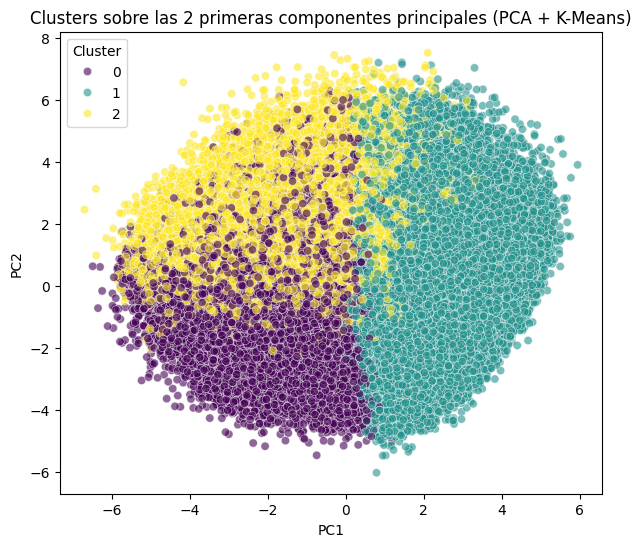


Porcentaje de fraudes por cluster:
fraud_bool          0         1
cluster                        
0           99.355432  0.644568
1           98.168026  1.831974
2           99.375954  0.624046


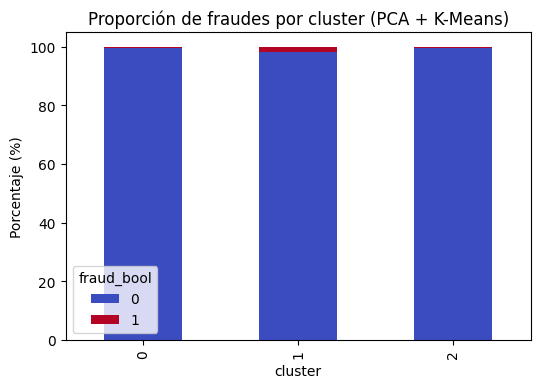

In [32]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ========= 1) Cargar dataset =========
# (usa el dataset original del caso práctico ya preprocesado)
df = X_train_enc.copy()
df['fraud_bool'] = y_train.values

# Eliminamos la variable objetivo
X = df.drop(columns=['fraud_bool'])

# ========= 2) Normalización =========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========= 3) Aplicar PCA (3 componentes principales) =========
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Convertimos a DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['fraud_bool'] = df['fraud_bool'].values

# Varianza explicada
print("\nVarianza explicada por cada componente PCA:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {var:.4f}")
print(f"Varianza total explicada: {pca.explained_variance_ratio_.sum():.4f}")

# ========= 4) Método del codo (Elbow Method) =========
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertia, 'o-', color='royalblue', linewidth=2)
plt.title('Método del codo (PCA + K-Means)')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.grid(True)
plt.show()

# ========= 5) Aplicar K-Means con número óptimo de clusters =========
# (selecciona k según el "codo" del gráfico, por ejemplo k=3)
k_opt = 3
kmeans_pca = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_pca)

# Añadimos los clusters al DataFrame
pca_df['cluster'] = clusters_pca

# ========= 6) Análisis general =========
print("\nNúmero de registros por cluster:")
print(pca_df['cluster'].value_counts())

# Medias por cluster
print("\nMedia de las componentes PCA por cluster:")
print(pca_df.groupby('cluster')[['PC1', 'PC2', 'PC3']].mean())

# ========= 7) Visualización 2D =========
plt.figure(figsize=(7,6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', alpha=0.6)
plt.title('Clusters sobre las 2 primeras componentes principales (PCA + K-Means)')
plt.legend(title='Cluster')
plt.show()

# ========= 8) Cruce con variable objetivo =========
fraud_cross = pd.crosstab(pca_df['cluster'], pca_df['fraud_bool'], normalize='index') * 100
print("\nPorcentaje de fraudes por cluster:")
print(fraud_cross)

fraud_cross.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(6,4))
plt.title('Proporción de fraudes por cluster (PCA + K-Means)')
plt.ylabel('Porcentaje (%)')
plt.show()


Se proporciona el código para realizar una visualización en 3D.

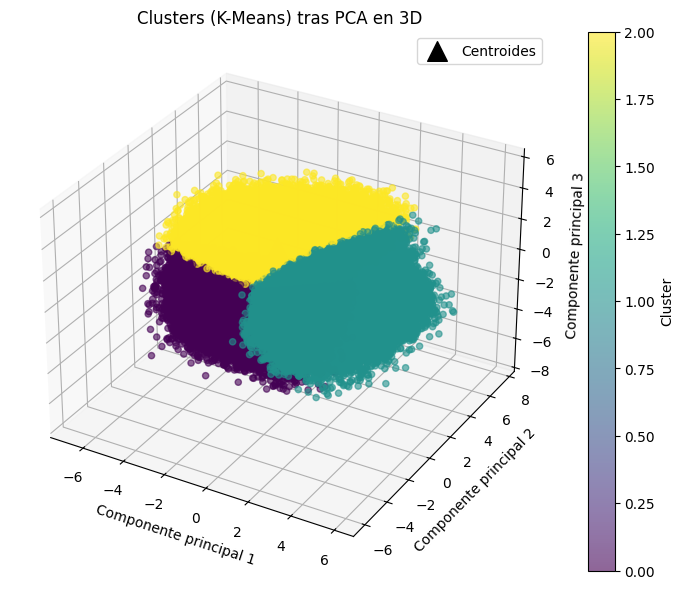

In [35]:
from mpl_toolkits.mplot3d import Axes3D  # Necesario para proyección 3D
import matplotlib.pyplot as plt

# ========= 1) Crear DataFrame de PCA y etiquetas =========
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['labels'] = kmeans_pca.labels_

# ========= 2) Obtener centroides del modelo K-Means =========
centroids = kmeans_pca.cluster_centers_

# ========= 3) Graficar en 3D =========
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Puntos de los clusters
scatter = ax.scatter(
    pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'],
    c=pca_df['labels'], cmap='viridis', alpha=0.6
)

# Centroides (triángulos negros)
ax.scatter(
    centroids[:, 0], centroids[:, 1], centroids[:, 2],
    marker='^', s=200, c='black', label='Centroides'
)

# Etiquetas y título
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
ax.set_title('Clusters (K-Means) tras PCA en 3D')

# Leyenda y colorbar
ax.legend()
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


Los tres clusters incluyen fraudes, pero el Cluster 1 concentra casi el triple de proporción de casos fraudulentos (1.83%) frente a los otros dos.

Esto sugiere que, aunque el PCA redujo la dimensionalidad sin usar la etiqueta fraud_bool, las transacciones con comportamientos más “extremos” en PC1 tienden a incluir más fraudes.

El Cluster 1 puede considerarse un segmento de mayor riesgo, mientras que los Clusters 0 y 2 agrupan transacciones más normales o de menor probabilidad de fraude.

El análisis combinado PCA + K-Means permitió identificar tres grandes grupos de transacciones en el dataset:

Dos clusters (0 y 2) con baja incidencia de fraude y comportamiento estable.

Un cluster (1) con mayor concentración de fraudes (1.83%), posiblemente asociado a operaciones más complejas o atípicas.

Aunque el PCA sólo explica un 16 % de la varianza, la reducción dimensional permite visualizar la estructura general y mejora la separabilidad geométrica.

Conclusión:
El flujo PCA → K-Means es útil para detectar segmentos de riesgo y patrones de comportamiento incluso en datasets ruidosos o de alta dimensionalidad, como los de detección de fraude.